In [8]:
# ----------------------------------------------------------------------------*
# SEIS 764 Artificial Intelligence
# Assignment 7 : Classify the images into the two classes 
# using SimpleRNN, GRU, and LSTM
# auther: Yann Mulonda - November 7, 2021
# ----------------------------------------------------------------------------*
# Import the libraries needed
import numpy as np
import pandas as pd
from glob import glob
import sys, os, zipfile
import tensorflow as tf
from google.colab import auth
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD, Adam
from oauth2client.client import GoogleCredentials
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Input, Dense, Flatten

In [9]:
# check which runtime GPU I'm using
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [10]:
# ----------------------------------------------------------------------------*
# Data from: https://mmspg.epfl.ch/downloads/food-image-datasets/
# Download the zip file saved in the Drive 
!pip install -U -q PyDrive

#File ID
zip_id = '1sajk-SXeemD-0JXDoTMezv3hlvoHUi4v'

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the zip file
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('flowers.zip')

# verified that the data has been downloaded
!ls

adc.json  flowers.zip  sample_data


In [11]:
# let's unzip the data
# -qq don't show ouput
!unzip -qq -o flowers.zip

In [12]:
# Show unzip data
!ls

adc.json  flowers.zip  roses_and_tulips  sample_data


In [13]:
# Show unzip data
!ls roses_and_tulips

roses  tulips


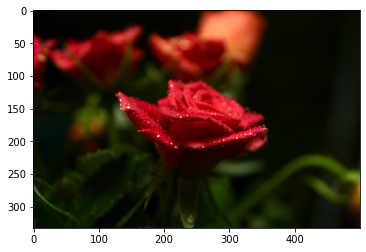

In [14]:
# Show sample rose data: check out an image
plt.imshow(image.load_img('roses_and_tulips/roses/3630246240_4fee9a33db.jpg'))
plt.show()

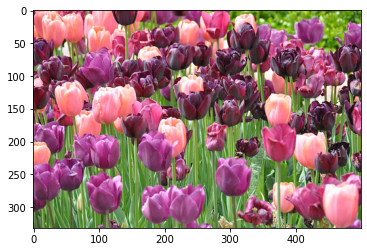

In [15]:
# Show sample tulips data: check out an image
plt.imshow(image.load_img('roses_and_tulips/tulips/5682463466_d3e641cb8b.jpg'))
plt.show()

In [16]:
# now let's set up the proper directory structure
# let start with creating the appropriate directories
# Make appropriate directories 
!mkdir data                           
!mkdir data/train
!mkdir data/test
!mkdir data/train/roses
!mkdir data/train/tulips
!mkdir data/test/roses
!mkdir data/test/tulips

In [17]:
# ----------------------------------------------------------------------------*
# Functions used
# **************
# show how many images storein a folder path
def howmanyImages(images_path):
  import glob
  images = glob.glob(images_path + '/*.jpg')
  count = 0
  for image in images:
    count = count + 1
    
  print(count, "images counted in", images_path)

# Ploting loss and Accuracy per iteration
def plotLossAndAccuracy(r):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
  # fig.suptitle('Loss and Accuracy per iteration')
  # Ploting loss
  ax1.plot(r.history['loss'], label='loss')
  ax1.plot(r.history['val_loss'], label='val_loss')
  ax1.set_title('Loss per iteration')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend()
  # Ploting Accuracy
  ax2.plot(r.history['accuracy'], label='acc')
  ax2.plot(r.history['val_accuracy'], label='val_acc')
  ax2.set_title('Accuracy per iteration')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

  fig.tight_layout()
  plt.show()

In [18]:
# now let's move the data to the appropriate directories
# Move the images
# Note: we will use 200 images for training and the remaining 100 for testing

# 200 rose images for training 
!mv roses_and_tulips/roses/*_m.jpg data/train/roses
!mv roses_and_tulips/roses/*_n.jpg data/train/roses
!mv roses_and_tulips/roses/*14* data/train/roses
!mv roses_and_tulips/roses/1392579828_ab5a139052.jpg data/train/roses

# 200 tulips images for training 
!mv roses_and_tulips/tulips/*_m.jpg data/train/tulips
!mv roses_and_tulips/tulips/*_n.jpg data/train/tulips
!mv roses_and_tulips/tulips/*13* data/train/tulips

In [19]:
# show number of images for training
howmanyImages('data/train/roses')
howmanyImages('data/train/tulips')

200 images counted in data/train/roses
200 images counted in data/train/tulips


In [20]:
# now move the remaining 100 rose images for testing
!mv roses_and_tulips/roses/*.jpg data/test/roses

# the remaining 100 tupils images for testing
!mv roses_and_tulips/tulips/*.jpg data/test/tulips

In [21]:
# show number of images for testing
howmanyImages('data/test/roses')
howmanyImages('data/test/tulips')

100 images counted in data/test/roses
100 images counted in data/test/tulips


In [22]:
# set up path for training and validation
train_path = 'data/train'
valid_path = 'data/test'

# process the image : standarization
# These images are pretty big and of different sizes
# Let's load them all in as the same (smaller) size
IMAGE_SIZE = [150, 150]

# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')
print('Number of images for training: ', len(image_files))
print('Number of images for validation: ', len(valid_image_files))

Number of images for training:  400
Number of images for validation:  200


In [23]:
# useful for getting number of classes
folders = glob(train_path + '/*')
print(folders)

['data/train/tulips', 'data/train/roses']
